<a href="https://colab.research.google.com/github/BlueBug12/stock/blob/master/bin/cloud/CNN_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 47.7MB/s 
     |████████████████████████████████| 460kB 51.3MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
!nvidia-smi

Mon Nov 16 09:30:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Dense, Activation,MaxPooling1D, GlobalAveragePooling1D, Dropout, Lambda, RepeatVector, Input, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math

In [2]:
print(tensorflow.__version__)

2.2.0


In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
ls

CNN_Classifier.ipynb  data/  models/


In [70]:
def buildYTrain(train, pastDay, futureDay,profit):
    Y_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
      sub_list=[]
      for j in range(futureDay):
        sub_list.append((train['close'][i+pastDay+j]-train['close'][i+pastDay-1])/train['close'][i+pastDay-1])
      Y_train.append(np.array(sub_list))
    Y_train = normalize_data(Y_train)
    return np.array(Y_train)

def buildXTrain(train, pastDay, futureDay,profit):
    X_train = []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
    return np.array(X_train)

def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [76]:
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
    print(df.tail())
    print(df.shape)
    df.drop(['year','week','month','day','adj_close'],axis=1,inplace=True)

      adj_close  close   high    low  ...     ema_D        RS        RSI       OBV
4102      458.0  458.5  460.0  454.0  ...  1.354608  2.197155  68.722188  0.750000
4103      451.0  451.0  454.5  448.5  ...  2.173993  1.186501  54.264824  0.416667
4104      456.5  457.0  457.0  448.5  ...  1.884128  1.611101  61.701972  1.000000
4105      457.5  458.0  463.5  457.5  ...  1.632911  1.692754  62.863303  0.083333
4106      461.5  462.0  462.0  456.5  ...  1.415189  2.069618  67.422656  1.000000

[5 rows x 36 columns]
(4107, 36)


In [77]:
past = 60
future = 5
profit = 0.01
val_ratio = 0.2
num_classes=2
data_y = buildYTrain(df.copy().iloc[:-100],past,future,profit)
#df.drop(['open','high','low','close'],axis=1,inplace=True)
data = normalize_data(df.copy().iloc[:-100])
data_x = buildXTrain(data,past,future,profit)

In [78]:
data_X, data_Y = shuffle(data_x, data_y)
x_train, y_train, x_val, y_val = splitData(data_X, data_Y, val_ratio)

In [79]:

x_train.shape
y_train.shape

(3154, 5)

In [101]:
backend.clear_session()

model = Sequential()
model.add(Conv1D(16, 3, activation='selu', input_shape=(x_train.shape[1:])))
model.add(Conv1D(16, 3, activation='selu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, 3, activation='selu'))
model.add(Conv1D(32, 3, activation='selu'))
model.add(MaxPooling1D(2))

model.add(Conv1D(64, 3, activation='selu'))
model.add(Conv1D(64, 3, activation='selu'))
model.add(Conv1D(64, 3, activation='selu'))
model.add(MaxPooling1D(2))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(MaxPooling1D(2))



#model.add(Conv1D(128, 3, activation='selu'))
#model.add(Conv1D(128, 3, activation='selu'))

#model.add(Conv1D(160, 3, activation='selu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.5))
#model.add(Flatten(input_shape=(x_train.shape[1:])))
model.add(Flatten())
model.add(Dense(512, activation='selu'))    
model.add(Dropout(0.5))    
model.add(Dense(512, activation='selu'))    
model.add(Dropout(0.5))

#for i in range(50):
#  model.add(Dense(512, activation='selu'))    
#model.add(Dropout(0.5)) 
#model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(future, activation='sigmoid'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 58, 16)            1504      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 32)            1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            6

Epoch 1/1000
99/99 [==============================] - 1s 7ms/step - loss: 0.1339 - accuracy: 0.2933 - val_loss: 0.0701 - val_accuracy: 0.3020
Epoch 2/1000
99/99 [==============================] - 1s 6ms/step - loss: 0.0764 - accuracy: 0.3855 - val_loss: 0.0685 - val_accuracy: 0.5330
Epoch 3/1000
99/99 [==============================] - 1s 6ms/step - loss: 0.0704 - accuracy: 0.4493 - val_loss: 0.0673 - val_accuracy: 0.5609
Epoch 4/1000
99/99 [==============================] - 1s 6ms/step - loss: 0.0682 - accuracy: 0.4537 - val_loss: 0.0677 - val_accuracy: 0.5444
Epoch 5/1000
99/99 [==============================] - 1s 6ms/step - loss: 0.0676 - accuracy: 0.4841 - val_loss: 0.0678 - val_accuracy: 0.5673
Epoch 6/1000
99/99 [==============================] - 1s 6ms/step - loss: 0.0671 - accuracy: 0.4705 - val_loss: 0.0681 - val_accuracy: 0.5660
Epoch 7/1000
99/99 [==============================] - 1s 6ms/step - loss: 0.0664 - accuracy: 0.4886 - val_loss: 0.0678 - val_accuracy: 0.5584
Epoch 

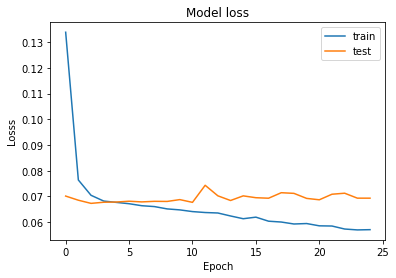

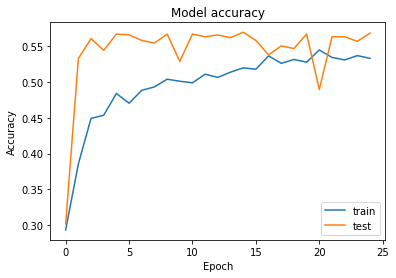

In [102]:
callback = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="auto")
history=model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val, y_val), callbacks=[callback])
training_result(history)

In [95]:
model.predict(x_train)

array([[0.48571333, 0.4490299 , 0.405476  , 0.3676657 , 0.4406003 ],
       [0.5082368 , 0.46651578, 0.42246348, 0.3913678 , 0.45977765],
       [0.49850026, 0.46414295, 0.42363963, 0.39425308, 0.46244252],
       ...,
       [0.5004892 , 0.46793708, 0.42209378, 0.3849002 , 0.45525348],
       [0.5101603 , 0.4779181 , 0.4298565 , 0.40044558, 0.46683103],
       [0.49886551, 0.46264258, 0.41759083, 0.3845056 , 0.4555898 ]],
      dtype=float32)